<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libs-and-Functions" data-toc-modified-id="Libs-and-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libs and Functions</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Understanding-the-Data" data-toc-modified-id="Understanding-the-Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Understanding the Data</a></span></li><li><span><a href="#Class-Balance" data-toc-modified-id="Class-Balance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Class Balance</a></span></li><li><span><a href="#Amount-Transaction-Analysis" data-toc-modified-id="Amount-Transaction-Analysis-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Amount Transaction Analysis</a></span></li><li><span><a href="#Fraud-Transaction-Relationship" data-toc-modified-id="Fraud-Transaction-Relationship-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Fraud Transaction Relationship</a></span></li></ul></li><li><span><a href="#Explained-Data-Prep" data-toc-modified-id="Explained-Data-Prep-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Explained Data Prep</a></span><ul class="toc-item"><li><span><a href="#Null-Data" data-toc-modified-id="Null-Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Null Data</a></span></li><li><span><a href="#Splitting-the-Data" data-toc-modified-id="Splitting-the-Data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Splitting the Data</a></span></li><li><span><a href="#Feature-Scaling" data-toc-modified-id="Feature-Scaling-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Feature Scaling</a></span></li></ul></li><li><span><a href="#Fraud-Detection" data-toc-modified-id="Fraud-Detection-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fraud Detection</a></span></li></ul></div>

Hi everyone! In this kernel we will explore something really common in fraud tasks: a highly unbalanced dataset. Our goal is to go trough Machine Learning models and apply some techniques that allow us to reach high classification scores (and we will see that accuracy is not one of them).

So, I hope you like this kernel and if you do so, please **upvote**. This will keep me motivated!

# Libs and Functions

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, learning_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            precision_recall_curve, f1_score, confusion_matrix, roc_curve, \
                            roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import itertools
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Let's define some useful functions to be used along this kernel.

In [12]:
def format_spines(ax, right_border=True):
    """
    This function sets up borders from an axis and personalize colors
    
    Input:
        Axis and a flag for deciding or not to plot the right border
    Returns:
        Plot configuration
    """    
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#CCCCCC')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')
    
def donut_plot(col, ax, df, text='', colors=['navy', 'crimson'], labels=['non-fraud', 'fraud']):
    """
    This function plots a customized donut chart for target label
    
    Input:
        Target column, axis to receive the plot, text to be in the center of the circle, colors and labels
    Output:
        A customized donut chart
    """
    sizes = df[col].value_counts().values
    #labels = df[col].value_counts().index
    center_circle = plt.Circle((0,0), 0.80, color='white')
    ax.pie((sizes[0], sizes[1]), labels=labels, colors=colors, autopct='%1.2f%%')
    ax.add_artist(center_circle)
    kwargs = dict(size=20, fontweight='bold', va='center')
    ax.text(0, 0, text, ha='center', **kwargs)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function sets up and plot a really cool Confusion Matrix
    
    Input:
        The confusion matriz already generated, normalizer, title and colors
    Output:
        A beautiful confusion matrix
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Format plot
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def create_dataset():
    """
    This functions creates a dataframe to receive the performance analysis
    
    Input:
        Nothing
    Output:
        An empty pandas DataFrame object with columns referencing the metrics to be evaluated on project
    """
    attributes = ['acc', 'prec', 'rec', 'f1', 'auc', 'total_time']
    model_performance = pd.DataFrame({})
    for col in attributes:
        model_performance[col] = []
        
    return model_performance

def model_analysis(classifiers, X, y, df_performance, cv=5, train=True):
    """
    This function brings up a full model evaluation and saves it in a DataFrame object
    
    Input:
        A dictionary of classifiers already trained, train data, train target and an empty dataframe
    Output:
        A DataFrame object with all metrics from all models on classifier's dictionary.
    """
    for key, model in classifiers.items():
        t0 = time.time()
        
        # Accuracy, precision, recall and f1_score on training set using cv
        if train:
            acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
            prec = cross_val_score(model, X, y, cv=cv, scoring='precision').mean()
            rec = cross_val_score(model, X, y, cv=cv, scoring='recall').mean()
            f1 = cross_val_score(model, X, y, cv=cv, scoring='f1').mean()
        else:
            y_pred = model.predict(X)
            acc = accuracy_score(y, y_pred)
            prec = precision_score(y, y_pred)
            rec = recall_score(y, y_pred)
            f1 = f1_score(y, y_pred)
        
        # AUC score
        try:
            y_scores = cross_val_predict(model, X, y, cv=5, 
                                     method='decision_function')
        except:
            # Trees don't have decision_function but predict_proba
            y_probas = cross_val_predict(model, X, y, cv=5, 
                                         method='predict_proba')
            y_scores_tree = y_probas[:, 1]
            y_scores = y_scores_tree
        auc = roc_auc_score(y, y_scores)
        
        t1 = time.time()
        delta_time = t1-t0
        model_name = model.__class__.__name__
        
        # Saving on dataframe
        performances = {}
        performances['acc'] = round(acc, 4)
        performances['prec'] = round(prec, 4)
        performances['rec'] = round(rec, 4)
        performances['f1'] = round(f1, 4)
        performances['auc'] = round(auc, 4)
        performances['total_time'] = round(delta_time, 3)        
        df_performance = df_performance.append(performances, ignore_index=True)
        
    df_performance.index = classifiers.keys()
    
    return df_performance

def model_confusion_matrix(classifiers, X, y, cmap=plt.cm.Blues):
    """
    This function computes predictions for all model and plots a confusion matrix for each one
    
    Input:
        A dictionary of classifiers already trained, X and y data to be evaluated
    Output:
        Beautiful confusion matrix for all the models
    """
    i = 1
    plt.figure(figsize=(11, 11))
    sns.set(style='white', palette='muted', color_codes=True)
    labels = ['Non-Fraud', 'Fraud']
    
    # Confusion matrix
    for key, model in classifiers.items(): 
        y_pred = model.predict(X)
        model_cf_mx = confusion_matrix(y, y_pred)
        model_name = model.__class__.__name__
        plt.subplot(3, 3, i)
        plot_confusion_matrix(model_cf_mx, labels, title=model_name + '\nConfusion Matrix', cmap=cmap)
        i += 1

    plt.tight_layout()
    plt.show()
    
def plot_roc_curve(fpr, tpr, y, y_scores, auc, label=None):
    """
    This function plots the ROC curve of a model
    
    Input:
        False Positive Rate, True Positive Rate, target label and scores from target label
    Output:
        ROC Curve for the model
    """   
    # Showing data
    sns.set(style='white', palette='muted', color_codes=True)
    plt.plot(fpr, tpr, linewidth=2, label=f'{label}, auc={auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.02, 1.02, -0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve', size=14)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', 
                 xy=(0.5, 0.5), xytext=(0.6, 0.4),
                 arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
def plot_learning_curve(trained_models, X, y, ylim=None, cv=5, n_jobs=1, 
                        train_sizes=np.linspace(.1, 1.0, 10)):
    """
    This functions plots the learning curve for the models using training and cross validation data
    
    Input:
        Models as a dictionary, X and Y data, y_lim, cv folds, n_jobs and the size of the tranining data
    Output:
        Learning curves for the models
    """
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(17, 17))
    if ylim is not None:
        plt.ylim(*ylim)
    i = 0
    j = 0
    for key, model in trained_models.items():
        train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, n_jobs=n_jobs, 
                                                                train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        axs[i, j].fill_between(train_sizes, train_scores_mean - train_scores_std,
                               train_scores_mean + train_scores_std, alpha=0.1, color='blue')
        axs[i, j].fill_between(train_sizes, test_scores_mean - test_scores_std,
                               test_scores_mean + test_scores_std, alpha=0.1, color='crimson')
        axs[i, j].plot(train_sizes, train_scores_mean, 'o-', color="navy",
                       label="Training score")
        axs[i, j].plot(train_sizes, test_scores_mean, 'o-', color="red",
                       label="Cross-Validation score")
        axs[i, j].set_title(f'{key} Learning Curve', size=14)
        axs[i, j].set_xlabel('Training size (m)')
        axs[i, j].set_ylabel('Score')
        axs[i, j].grid(True)
        axs[i, j].legend(loc='best')
        j += 1
        if j == 2:
            i += 1
            j = 0

# Exploratory Data Analysis

After importing libraries and defining functions, we will explore the data in order to build a knowledge about it and be aware of preparations and techiniques to be used along the project. As states in the description of this dataset, we will deal with an unbalanced target class of fraudulent credit card transactions. Let's see on details.

## Understanding the Data

In [8]:
df = pd.read_csv('/home/paninit/Downloads/datasets/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Well, for understanding the columns and its meaning, nothing better than the dataset description itself provided on the page: 

_"It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise."_

But we really need to get inside the data to extract information! So there are some things that can be done:

    - Plot the balance of target class (we already have this information but it's good to document);
    - See some statistics about the Amount feature;
    - Look for correlations between Amount and Class

## Class Balance

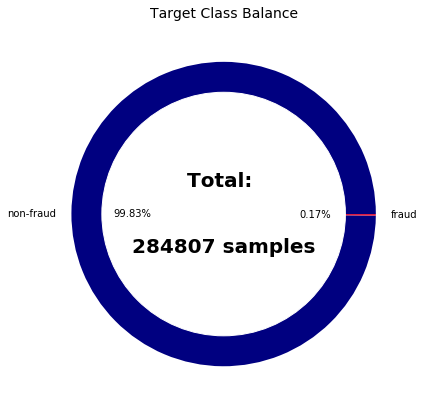

In [22]:
fig, ax = plt.subplots(figsize=(7, 7))
text = f'Total: \n\n\n{str(len(df))} samples'
donut_plot(col='Class', ax=ax, df=df, text=text)
ax.set_title('Target Class Balance', size=14)
plt.show()

Really unbalanced! Some techniques to be applied in the future: RandomUndersampling for undersampling and SMOTE for oversampling.

## Amount Transaction Analysis

In [23]:
df['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

The mean value of transactions in this dataset is 88.35 with 250.12 of standard deviation (a high one in this case). The minimun transaction recorded is 0.00 and the maximum one is 25,691.16

It seems that we have a long tail distribution.

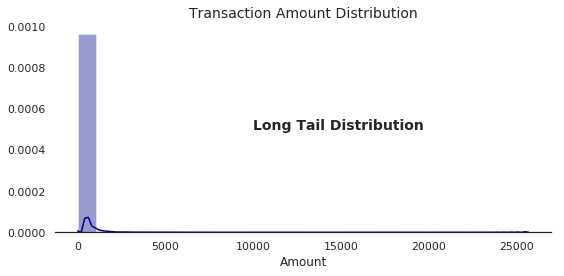

In [66]:
sns.set(style='white', palette='muted', color_codes=True)
fig, ax = plt.subplots(figsize=(8, 4))
sns.despine(left=True)

sns.distplot(df['Amount'], bins=25, color='navy')
ax.text(10000.8088, .0005, 'Long Tail Distribution', weight='bold', size=14)
ax.set_title('Transaction Amount Distribution', size=14)
plt.setp(axs, yticks=[])
plt.tight_layout()
plt.show()

In [ ]:
# Outliers
fig, axs = plt.subplots(figsize=(14, 5))
sns.boxplot(x='Amount', data=df)

sns.boxplot(x='risk', y='credit_amount', data=df, ax=axs[0], palette='inferno')
sns.boxplot(x='saving_accounts', y='credit_amount', data=df, ax=axs[1], palette='inferno')
axs[0].annotate('Some extreme \n      outliers', xy=(0.99, 16000), xytext=(0.2, 17000),
            arrowprops=dict(facecolor='black'), fontsize=14)
axs[0].annotate('', xy=(0.99, 18300), xytext=(0.83, 18000),
            arrowprops=dict(facecolor='black'), fontsize=14)
axs[0].annotate('', xy=(0.02, 15700), xytext=(0.20, 17500),
            arrowprops=dict(facecolor='black'), fontsize=14)
axs[1].annotate('Some extreme \n      outliers', xy=(0.05, 18300), xytext=(1.690, 17000),
            arrowprops=dict(facecolor='black'), fontsize=14)
axs[1].annotate('', xy=(2.95, 15000), xytext=(2.70, 17500),
            arrowprops=dict(facecolor='black'), fontsize=14)
plt.savefig('boxplot.png')
plt.show()

## Fraud Transaction Relationship

Now let's see if there is any relationship between amount and fraudulent transactions. First, let's see the amount recorded from transactions over time.

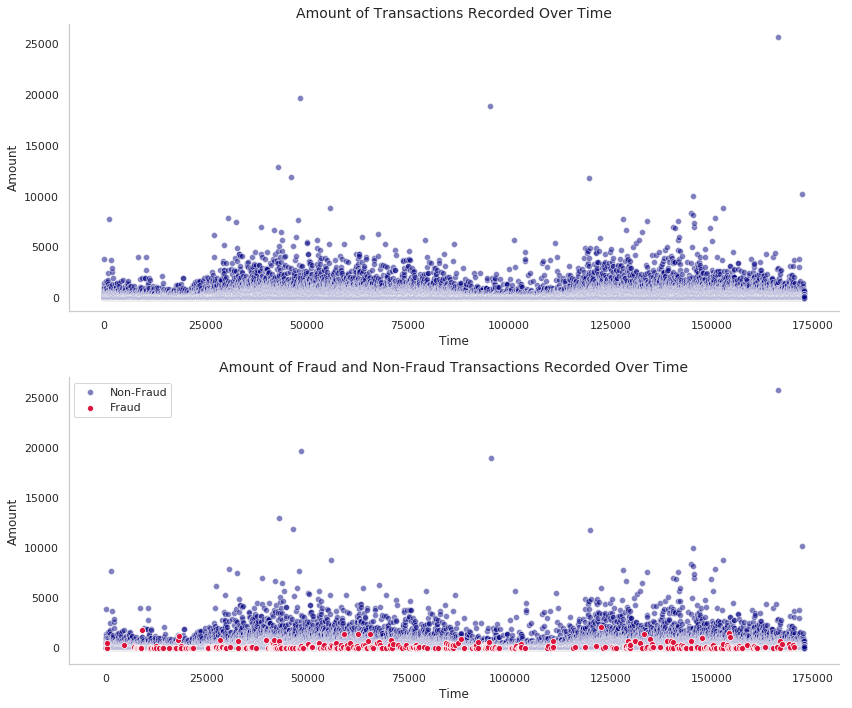

In [88]:
frauds = df.query('Class == 1')
non_frauds = df.query('Class == 0')
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
sns.scatterplot(x='Time', y='Amount', data=df, alpha=.5, color='navy', ax=axs[0])
sns.scatterplot(x='Time', y='Amount', data=non_frauds, alpha=.5, color='navy', label='Non-Fraud', ax=axs[1])
sns.scatterplot(x='Time', y='Amount', data=frauds, color='crimson', label='Fraud', ax=axs[1])
format_spines(axs[0], right_border=False)
format_spines(axs[1], right_border=False)
axs[0].set_title('Amount of Transactions Recorded Over Time', size=14)
axs[1].set_title('Amount of Fraud and Non-Fraud Transactions Recorded Over Time', size=14)
plt.tight_layout()
plt.show()

We see here some outliers (transactions with really high values) but we can see with the second row plot that those outliers are not related with fraudulent transactions. Another thing here that it'important to see is that maybe the `Time` column are not representative for fraud classification. 

# Explained Data Prep

For now we just knew briefly our data. In the next steps, we will explore it looking forward for preparing a pipeline for data preparation and model tranining. Let's go.

## Null Data

In [89]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Good! There's no null values on our dataset. Keep moving!

## Splitting the Data

Now we will create a Traning and a Test set to train and evaluate a Machine Learning model using a Classification Task (Supervised Learning) but before that, we will drop the `Time` column as long as it doesn't influence the fraud detection.

In [93]:
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

print(f'X_train dimension: {X_train.shape}')
print(f'y_train dimension: {y_train.shape}')
print(f'\nX_test dimension: {X_test.shape}')
print(f'y_test dimension: {y_test.shape}')

X_train dimension: (227845, 29)
y_train dimension: (227845,)

X_test dimension: (56962, 29)
y_test dimension: (56962,)


Just to be sure, let's look the proportion of our target class on training and test set.

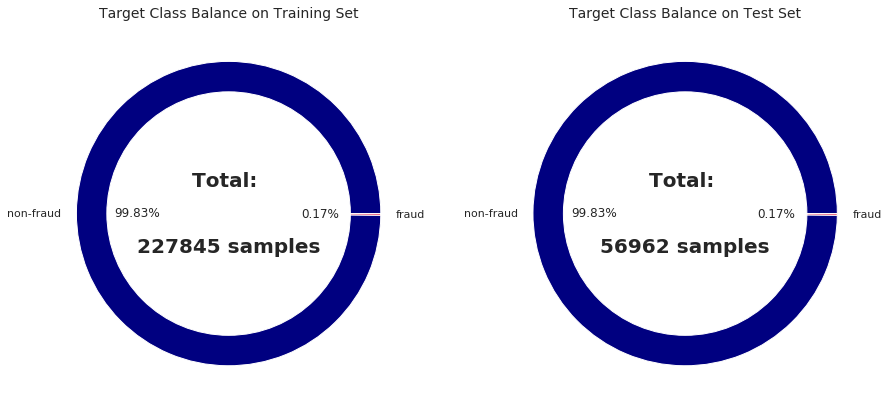

In [101]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)
text1 = f'Total: \n\n\n{str(len(y_train))} samples'
text2 = f'Total: \n\n\n{str(len(y_test))} samples'
donut_plot(col='Class', ax=axs[0], df=y_train_df, text=text1)
donut_plot(col='Class', ax=axs[1], df=y_test_df, text=text2)
axs[0].set_title('Target Class Balance on Training Set', size=14)
axs[1].set_title('Target Class Balance on Test Set', size=14)
plt.show()

## Feature Scaling

We know that all the attributes except Amount is originated from a PCA dimensionality reduction algorithm. But we also know that we have some outliers in Amount attribute that needs to be scaled before training a model.

In [109]:
scaler = StandardScaler()
X_train['Amount'] = scaler.fit_transform(X_train['Amount'].values.reshape(-1, 1))
X_train.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
223361,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,-0.030441,...,-0.125390,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,-0.307889
165061,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,0.611115,...,-0.470372,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,-0.167026
238186,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,-0.638222,...,0.012227,-0.314638,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288,-0.300043
150562,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,0.560595,...,-0.253757,0.063525,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931,0.113600
138452,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,1.221746,...,-0.012320,-0.480691,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672,-0.246029


As the other features (V1 to V28) seems to be already scaled, we will create a class for just perform the standard scaling on Amount attribute,

In [110]:
class AmountScaling(BaseEstimator, TransformerMixin):
    
    def fit (self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['Amount'] = scaler.fit_transform(X['Amount'].values.reshape(-1, 1))
        
        return X

So after the data exploration, we concluded that just one operation (Amount scaling) is needed. It's possible to create a pipeline to include this operation for threat new data. For now we will just use the class above for preparing the data.

# Fraud Detection

In [ ]:
classifiers = {
    'log_reg': LogisticRegression(),
    'tree_clf': DecisionTreeClassifier(),
    'forest_clf': RandomForestClassifier(),
    'svm_clf': SVC(),
    'knn_clf': KNeighborsClassifier(),
    'mlp_clf': MLPClassifier()
}

trained_models = {}

for key, model in classifiers.items():
    model.fit(X_train, y_train)
    trained_models[key] = model

Now, let's evaluate the performance of our models using **accuracy**, **precision**, **recall**, **f1_score**, **auc_score** and **time spent on evaluation**. It is important to compare the metrics to evaluate the behavior of each one of the models.

All metrics will be evaluated using cross-validation on training set with cv=5.

In [36]:
# Creating dataframe to hold metrics
train_performance = create_dataset()

# Evaluating models
train_performance = model_analysis(trained_models, X_train, y_train, train_performance)

# Result
cm = sns.light_palette("cornflowerblue", as_cmap=True)
train_performance.style.background_gradient(cmap=cm)

,acc,prec,rec,f1,auc,total_time
log_reg,0.6907,0.59,0.3033,0.3966,0.6598,0.061
tree_clf,0.611,0.4025,0.4479,0.4141,0.5611,0.108
forest_clf,0.6509,0.4743,0.3081,0.3194,0.604,0.277
svm_clf,0.6983,0.7047,0.1857,0.2916,0.6716,0.37
knn_clf,0.6524,0.4764,0.2897,0.3596,0.6171,0.152
mlp_clf,0.6923,0.5737,0.353,0.4297,0.6792,8.403
